In [ ]:

import lightgbm as lg
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import average_precision_score
import numpy as np
import wandb
from wandb.lightgbm import wandb_callback, log_summary

1. Load data

In [ ]:
train_df = pd.read_csv('/Users/favea/Downloads/swiss-data/train_df.csv' ,index_col=0)

In [ ]:
before_flights = pd.read_csv('/Users/favea/Downloads/swiss-data/previous_delayed_same_day.csv').drop('Unnamed: 0',axis=1)

In [ ]:
train_df = train_df.merge(before_flights, left_on='id_flight', right_on='wh_fleg_leg_i')

In [ ]:
train_df.columns

In [ ]:
columns_to_remove = ['ac_subtype','wh_fleg_leg_i','id_flight','carrier','season_trip','delay_minutes','scheduled_time_departure','year']

In [ ]:
#train_df = pd.read_csv('/Users/favea/Downloads/swiss-data/train_df.csv' ,index_col=0)
train_df = train_df.drop(columns_to_remove,axis=1)
x_train, y_train = train_df.drop('delayed',axis=1), train_df.loc[:,'delayed']
#x_train.carrier = x_train.carrier.astype('category')
x_train.origin = x_train.origin.astype('category')
x_train.destination = x_train.destination.astype('category')
#x_train.previous_is_delayed = x_train.previous_is_delayed.astype('category')
#x_train.ac_subtype = x_train.ac_subtype.astype('category')
x_train.ac_registration_code = x_train.ac_registration_code.astype('category')
x_train.previous_is_delayed_same_day = x_train.previous_is_delayed_same_day.astype('category')

lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = ['origin','destination','ac_registration_code','previous_is_delayed_same_day'], free_raw_data=False)

In [ ]:
train_df.shape

In [ ]:
dev_df = pd.read_csv('/Users/favea/Downloads/swiss-data/dev_df.csv', index_col=0)

In [ ]:
dev_df = dev_df.merge(before_flights, left_on='id_flight', right_on='wh_fleg_leg_i')

In [ ]:
dev_df.head()

In [ ]:

dev_df = dev_df.drop(columns_to_remove,axis=1)

x_dev, y_dev = dev_df.drop('delayed',axis=1), dev_df.loc[:,'delayed']
#x_dev.carrier = x_dev.carrier.astype('category')
x_dev.origin = x_dev.origin.astype('category')
x_dev.destination = x_dev.destination.astype('category')
#x_dev.previous_is_delayed = x_dev.previous_is_delayed.astype('category')

#x_dev.ac_subtype = x_dev.ac_subtype.astype('category')
x_dev.ac_registration_code = x_dev.ac_registration_code.astype('category')
x_dev.previous_is_delayed_same_day = x_dev.previous_is_delayed_same_day.astype('category')
lgb_dev = lgb.Dataset(x_dev, y_dev, reference=lgb_train, categorical_feature =['origin','destination','ac_registration_code','previous_is_delayed_same_day'], free_raw_data=False)

2. Train baseline

In [ ]:
train_df.shape, dev_df.shape

In [ ]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss','auc','average_precision'],
    'num_leaves': 1000,
    'learning_rate': 0.02,
    'feature_fraction': 1,
    'verbosity': 1,
    'scale_pos_weight': 2,
}

wandb.init(project='swiss-delay-prediction', job_type= 'training-lightgbm-2-baseline', config=params, reinit=True)

In [ ]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10_000,
                valid_sets=lgb_dev,
                valid_names=('validation'),
                callbacks=[wandb_callback()],
                early_stopping_rounds=20,
                )

In [ ]:
log_summary(gbm, save_model_checkpoint=True)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_recall_fscore_support, roc_curve

In [ ]:
# predict
y_pred = gbm.predict(x_dev, num_iteration=gbm.best_iteration)

roc_ac = roc_auc_score(y_dev, y_pred)
wandb.log({'roc_auc': roc_ac})

In [ ]:
wandb.sklearn.plot_confusion_matrix(y_dev, (y_pred>=0.5).astype(int))

In [ ]:
y_train_pred = gbm.predict(x_train, num_iteration=gbm.best_iteration)
print(classification_report(y_train, (y_train_pred>=0.5).astype(int)))

In [ ]:
d = classification_report(y_dev, (y_pred>=0.5).astype(int), output_dict=True)
sensitivity = d['1']['recall']
specificity = d['0']['recall']
f1_score = d['macro avg']['f1-score']

wandb.summary['sensitivity'] = sensitivity
wandb.summary['specificity'] = specificity
wandb.summary['f1_score'] = f1_score

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_dev, y_pred) 

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [ ]:
display = PrecisionRecallDisplay.from_predictions(    
    y_dev,
    y_pred,
    color="darkorange",
    name = 'LightGBM'
)
plt.plot()
wandb.log({'PR-curve':wandb.Image(plt)})

In [ ]:
RocCurveDisplay.from_predictions(
    y_dev,
    y_pred,
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

wandb.log({'ROC-curve':wandb.Image(plt)})

In [ ]:
wandb.finish()

## SWEEP

For heavily unbalanced datasets such as 1:10000:

max_bin: keep it only for memory pressure, not to tune (otherwise overfitting)

learning rate: keep it only for training speed, not to tune (otherwise overfitting)

n_estimators: must be infinite (like 9999999) and use early stopping to auto-tune (otherwise overfitting)

num_leaves: [7, 4095]

max_depth: [2, 63] and infinite (I personally saw metric performance increases with such 63 depth with small number of leaves on sparse unbalanced datasets)

scale_pos_weight: [1, 10000] (if over 10000, something might be wrong because I never saw it that good after 5000)

min_child_weight: [0.01, (sample size / 1000)] if you are using logloss (think about the hessian possible value rang
e before putting "sample size / 1000", it is dataset-dependent and loss-dependent)


subsample: [0.4, 1]


bagging_freq: only 1, keep as is (otherwise overfitting)

colsample_bytree: [0.4, 1]

is_unbalance: false (make your own weighting with scale_pos_weight)

USE A CUSTOM METRIC (to reflect reality without weighting, otherwise you have weights inside your metric with premade metrics like xgboost)

Never tune these parameters unless you have an explicit requirement to tune them:

Learning rate (lower means longer to train but more accurate, higher means smaller to train but less accurate)

Number of boosting iterations (automatically tuned with early stopping and learning rate)

Maximum number of bins (RAM dependent)

In [ ]:
sweep_config = {
  "method" : "bayes",
  "metric": {
      "name": "avg_precision_dev",
      "goal": "maximize"
  },
  "parameters" : {
    "gamma" :{
      "min": 0.001,
      "max": 1.0
    },
    "min_child_weight" :{
      "min": 1,
      "max": 150
    },
    "scale_pos_weight":{
      "min": 1,
      "max": 5
    },
    "num_leaves" :{
      "min": 10000,
      "max": 40000
    },
    "max_depth" :{
      "min": 3,
      "max": 60
    },
    "lambda_l1":{"values":[0.5, 0.8, 1]},
    "lambda_l2":{"values":[0.5, 0.8, 1]},

  }
}


In [ ]:
def train():     
    with wandb.init() as run:

        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': ['binary_logloss','average_precision'],
            'num_leaves': run.config['num_leaves'],
            'learning_rate': 0.025,
            'feature_fraction': 1,
            'bagging_freq': 1,
            'verbosity': 1,
            'scale_pos_weight': run.config['scale_pos_weight'],
            'lambda_l2':run.config['lambda_l2'],
            'lambda_l1':run.config['lambda_l1'],

        }
    

        # Initialize and train LightGBM model
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=5_000, #infinite
                        valid_sets=lgb_dev,
                        valid_names=('validation'),
                        callbacks=[wandb_callback()],
                        early_stopping_rounds=20,
                        )

        log_summary(gbm, save_model_checkpoint=True)
        


        # Log booster metrics
        run.summary["best_score"] = gbm.best_score
        run.summary["best_iteration"] = gbm.best_iteration
        
        # Get train and validation predictions
        y_dev_pred = gbm.predict(x_dev, num_iteration=gbm.best_iteration)
        y_train_pred = gbm.predict(x_train, num_iteration=gbm.best_iteration)


        # Log additional Train metrics
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, y_train_pred) 

        avg_precision_train = average_precision_score(y_train, y_train_pred)
        run.summary['train_avg_precision'] = avg_precision_train
        run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
        run.summary['train_log_loss'] = -(y_train * np.log(y_train_pred) + (1-y_train) * np.log(1-y_train_pred)).sum() / len(y_train)

        # Log additional Validation metrics
        avg_precision_dev = average_precision_score(y_dev, y_dev_pred)
        run.summary['avg_precision_dev'] = avg_precision_dev
        run.summary["val_auc"] = metrics.roc_auc_score(y_dev, y_dev_pred)
        run.summary["val_acc_0.5"] = metrics.accuracy_score(y_dev, np.where(y_dev_pred >= 0.5, 1, 0))
        run.summary["val_log_loss"] = -(y_dev * np.log(y_dev_pred) 
                                             + (1-y_dev) * np.log(1-y_dev_pred)).sum() / len(y_dev)

        d = classification_report(y_dev, np.where(y_dev_pred >= 0.5, 1, 0), output_dict=True)
        sensitivity = d['1']['recall']
        specificity = d['0']['recall']
        f1_score = d['macro avg']['f1-score']

        run.summary['val_sensitivity_0.5'] = sensitivity
        run.summary['val_specificity_0.5'] = specificity
        run.summary['val_f1_score_0.5'] = f1_score


        # Log plots
        RocCurveDisplay.from_predictions(
            y_dev,
            y_dev_pred,
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        run.log({'ROC-curve-dev':wandb.Image(plt)})

        display = PrecisionRecallDisplay.from_predictions(    
            y_dev,
            y_dev_pred,
            color="darkorange",
            name = 'LightGBM'
        )
        plt.plot()
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.legend()
        run.log({'PR-curve-dev':wandb.Image(plt)})
        try:
            wandb.sklearn.plot_confusion_matrix(y_dev, (y_dev_pred>=0.5).astype(int))
        except:
            pass


        #run.log({'feature_importance':fig})

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="swiss-delay-prediction")

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
avg_precision_dev,0.38707
best_iteration,31
iteration,50
train_auc,0.93672
train_avg_precision,0.69945
train_log_loss,0.36736
val_acc_0.5,0.81958
val_auc,0.73321


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jq596y1n with config:
wandb: 	gamma: 0.22425461834662053
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.8
wandb: 	max_depth: 35
wandb: 	min_child_weight: 150
wandb: 	num_leaves: 30484
wandb: 	scale_pos_weight: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▃▅▇▇▇▇█████████████████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_precision_dev,0.38312
best_iteration,55
iteration,74
train_auc,0.95532
train_avg_precision,0.79363
train_log_loss,0.32157
val_acc_0.5,0.81621
val_auc,0.73474


wandb: Agent Starting Run: 9a55ryrh with config:
wandb: 	gamma: 0.14400404117167168
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 11
wandb: 	min_child_weight: 107
wandb: 	num_leaves: 27139
wandb: 	scale_pos_weight: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_average_precision,▁▄▅▆▇▇▇▇▇▇██████████████████████████████
validation_binary_logloss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_precision_dev,0.38482
best_iteration,61
iteration,80
train_auc,0.96625
train_avg_precision,0.84055
train_log_loss,0.30544
val_acc_0.5,0.81453
val_auc,0.73555


wandb: Agent Starting Run: abd03d5x with config:
wandb: 	gamma: 0.09033734246641675
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 3
wandb: 	min_child_weight: 95
wandb: 	num_leaves: 36135
wandb: 	scale_pos_weight: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_average_precision,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
validation_binary_logloss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃
avg_precision_dev,0.38035
best_iteration,19
iteration,38
train_auc,0.9146
train_avg_precision,0.61202
train_log_loss,0.39882
val_acc_0.5,0.81627
val_auc,0.73027


wandb: Agent Starting Run: 30svqn7a with config:
wandb: 	gamma: 0.13528705506229857
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 11
wandb: 	min_child_weight: 145
wandb: 	num_leaves: 30631
wandb: 	scale_pos_weight: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
avg_precision_dev,0.38707
best_iteration,31
iteration,50
train_auc,0.93672
train_avg_precision,0.69945
train_log_loss,0.36736
val_acc_0.5,0.81958
val_auc,0.73321


wandb: Agent Starting Run: gerraq05 with config:
wandb: 	gamma: 0.11926691366211968
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 16
wandb: 	min_child_weight: 118
wandb: 	num_leaves: 27851
wandb: 	scale_pos_weight: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
avg_precision_dev,0.38707
best_iteration,31
iteration,50
train_auc,0.93672
train_avg_precision,0.69945
train_log_loss,0.36736
val_acc_0.5,0.81958
val_auc,0.73321


wandb: Agent Starting Run: 9wx0uff1 with config:
wandb: 	gamma: 0.01763016323953643
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 30
wandb: 	min_child_weight: 124
wandb: 	num_leaves: 31275
wandb: 	scale_pos_weight: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
avg_precision_dev,0.38707
best_iteration,31
iteration,50
train_auc,0.93672
train_avg_precision,0.69945
train_log_loss,0.36736
val_acc_0.5,0.81958
val_auc,0.73321


wandb: Agent Starting Run: s99o6vlg with config:
wandb: 	gamma: 0.073038081094184
wandb: 	lambda_l1: 0.8
wandb: 	lambda_l2: 0.8
wandb: 	max_depth: 45
wandb: 	min_child_weight: 143
wandb: 	num_leaves: 38563
wandb: 	scale_pos_weight: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_precision_dev,0.38581
best_iteration,30
iteration,49
train_auc,0.933
train_avg_precision,0.68447
train_log_loss,0.37073
val_acc_0.5,0.81931
val_auc,0.73228


wandb: Agent Starting Run: zcbbbhe8 with config:
wandb: 	gamma: 0.2401920584415777
wandb: 	lambda_l1: 1
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 16
wandb: 	min_child_weight: 131
wandb: 	num_leaves: 33609
wandb: 	scale_pos_weight: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
validation_binary_logloss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
avg_precision_dev,0.38707
best_iteration,31
iteration,50
train_auc,0.93672
train_avg_precision,0.69945
train_log_loss,0.36736
val_acc_0.5,0.81958
val_auc,0.73321


wandb: Agent Starting Run: ehmb3pht with config:
wandb: 	gamma: 0.1729071929010933
wandb: 	lambda_l1: 0.8
wandb: 	lambda_l2: 0.5
wandb: 	max_depth: 34
wandb: 	min_child_weight: 139
wandb: 	num_leaves: 39304
wandb: 	scale_pos_weight: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/favea/miniconda3/envs/swiss/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 23971, number of negative: 106504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 130475, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183721 -> initscore=-1.491338
[LightGBM] [Info] Start training from score -1.491338


wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'scale_pos_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lambda_l1' was locked by 'sweep' (ignored update).


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

wandb: Ctrl + C detected. Stopping sweep.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_average_precision,▁▃▅▅▆▇▇▇▇▇▇▇▇█▇▇████████████████████████
validation_binary_logloss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,50


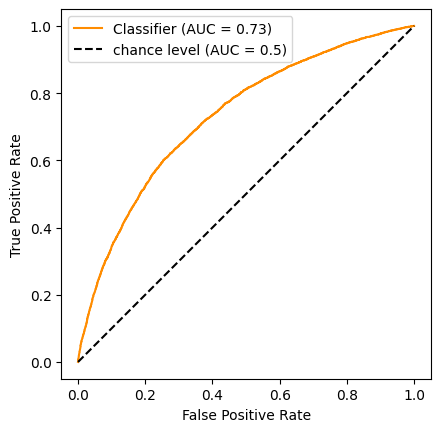

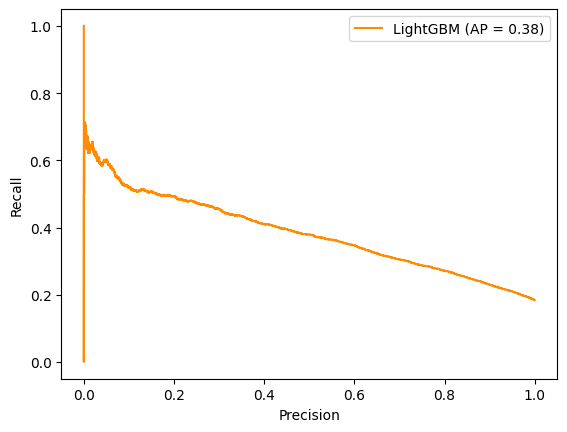

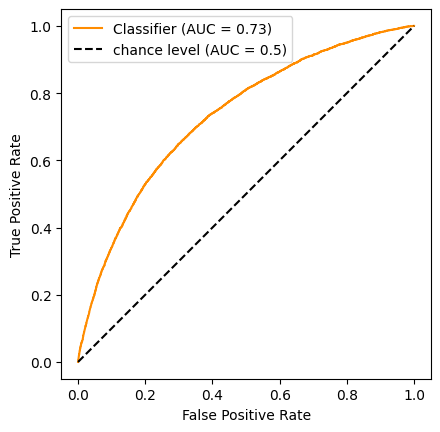

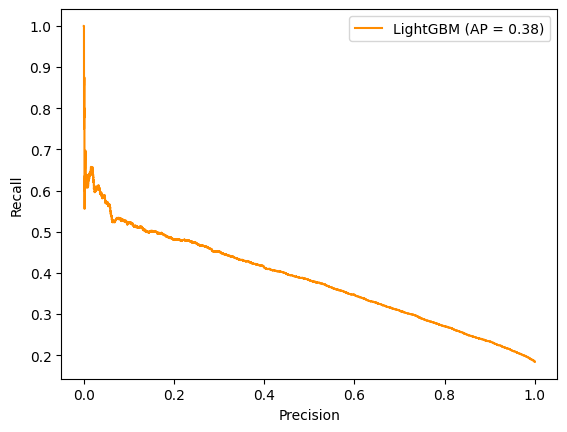

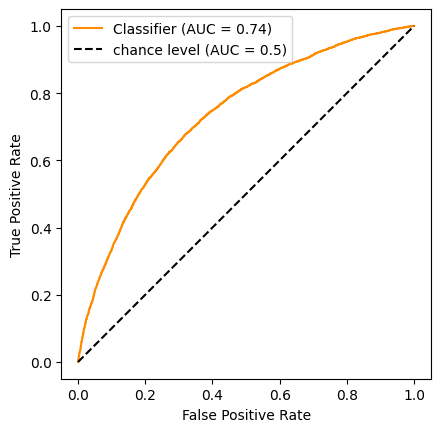

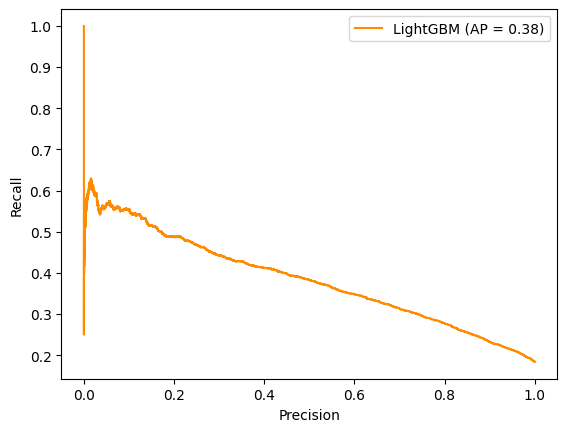

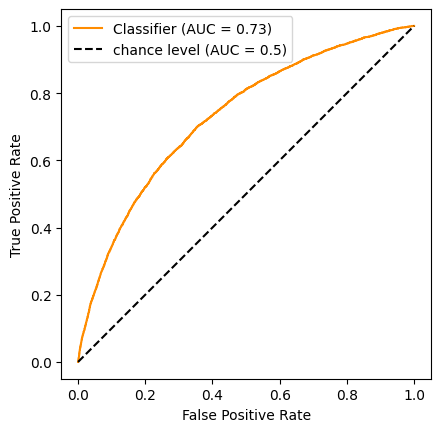

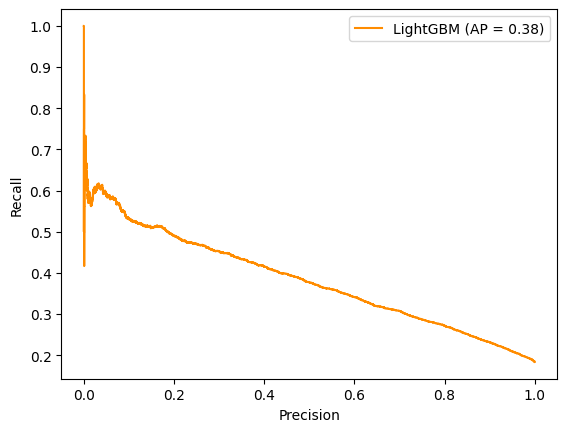

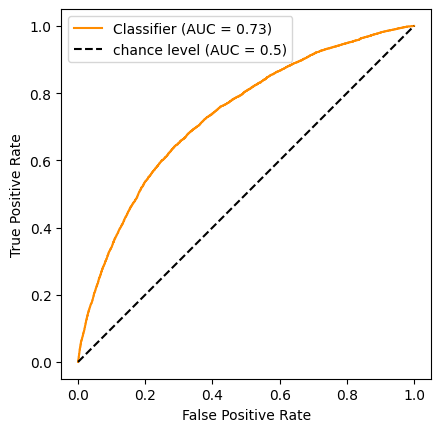

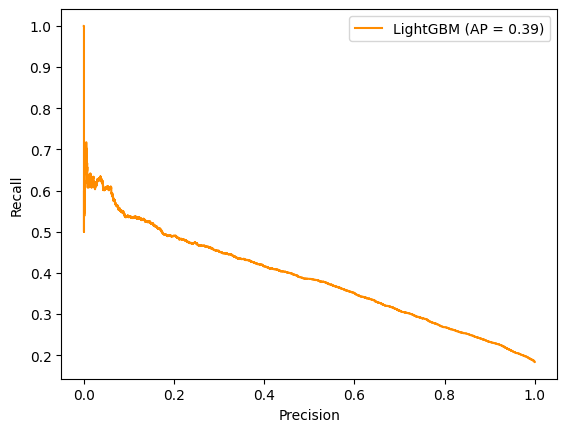

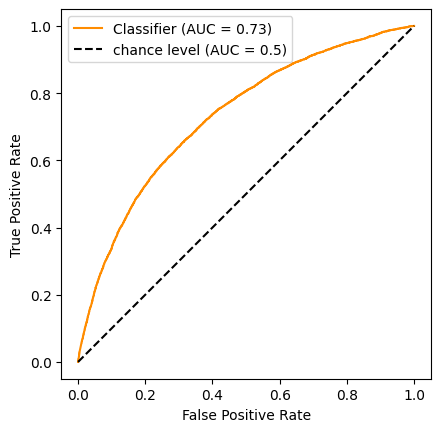

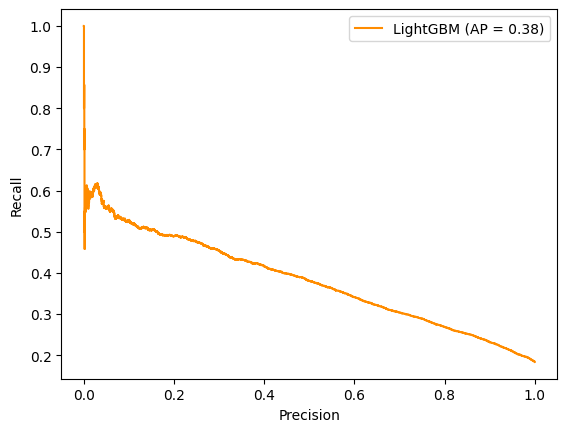

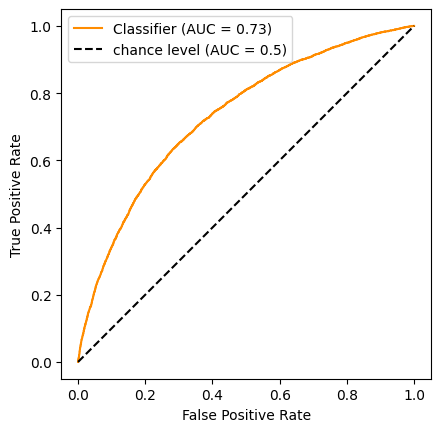

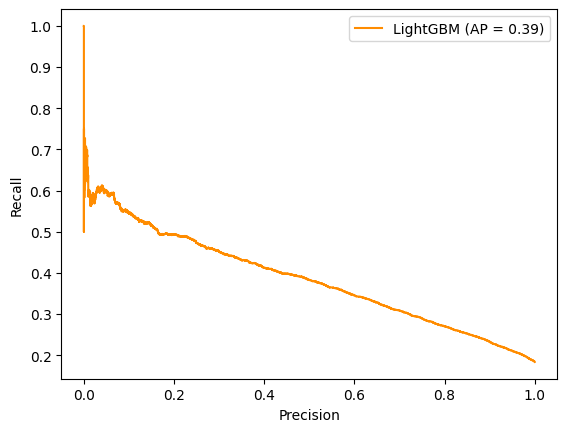

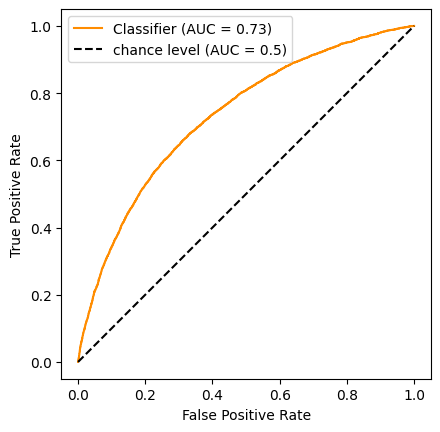

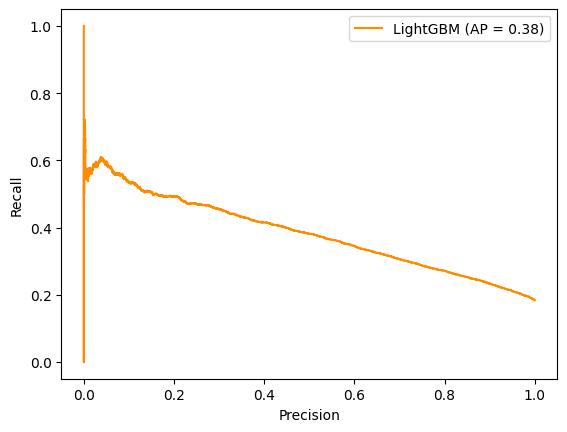

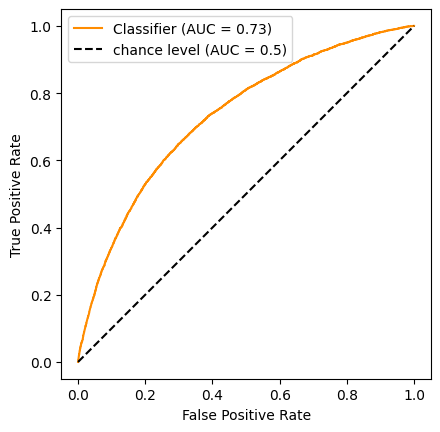

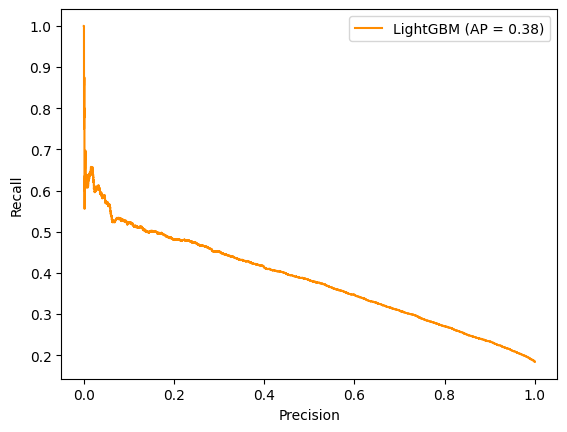

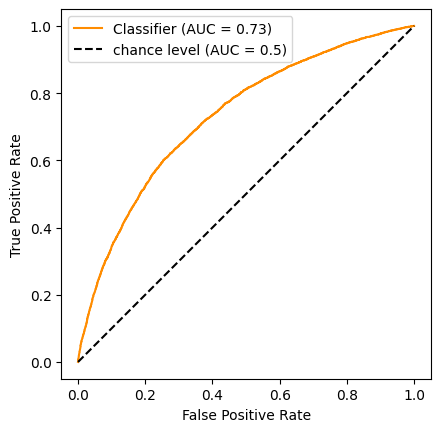

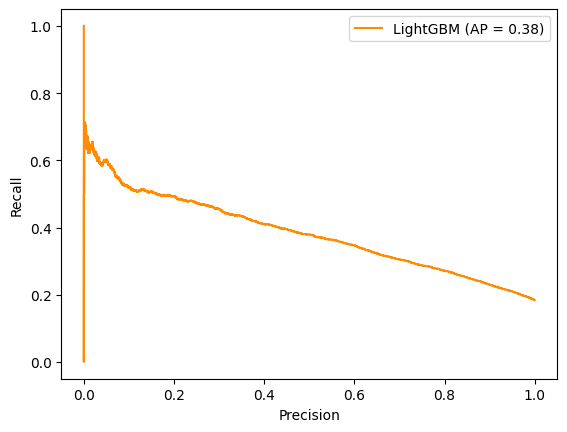

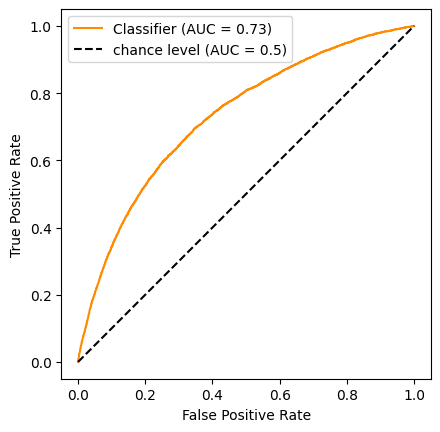

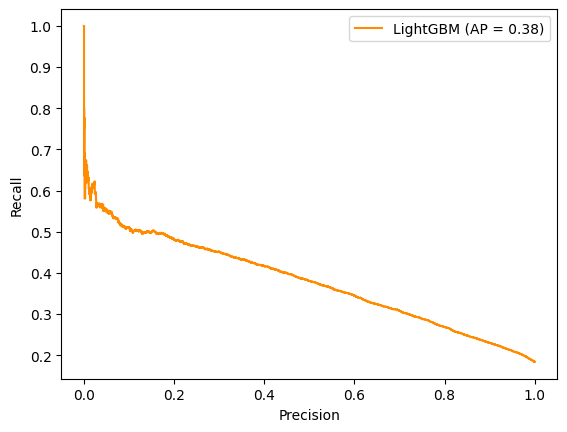

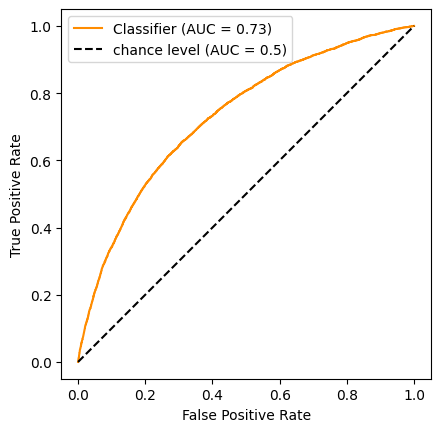

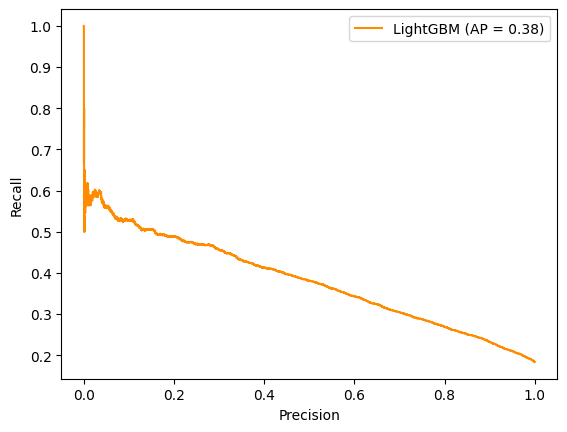

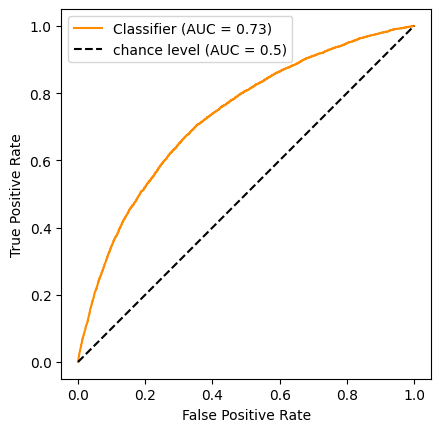

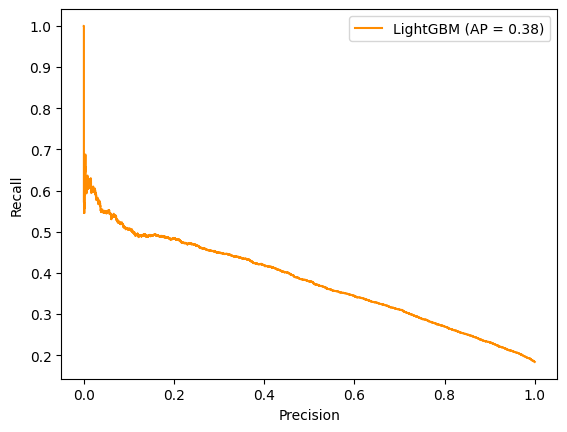

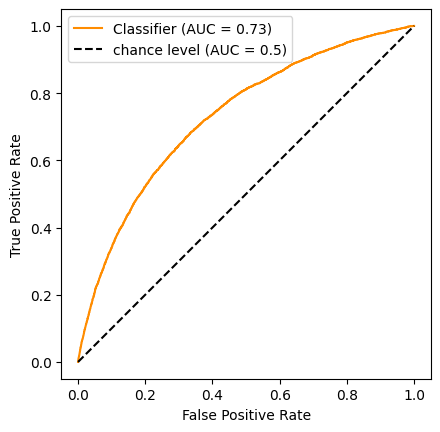

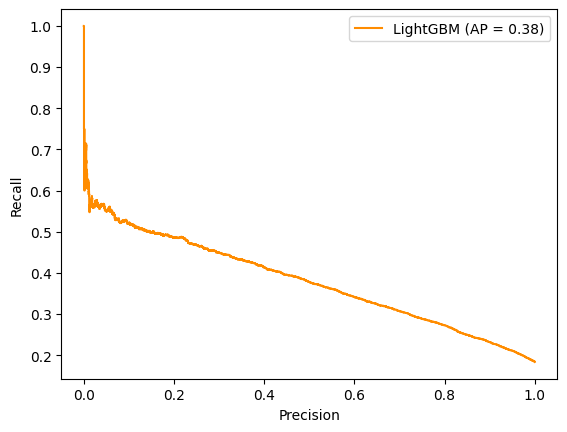

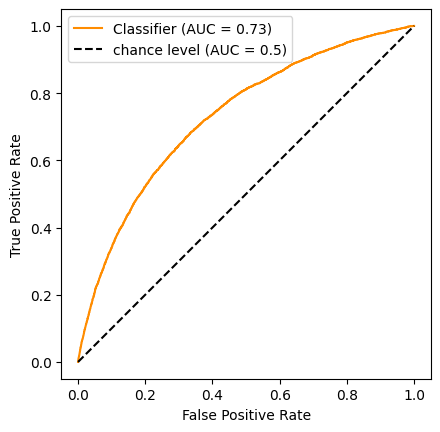

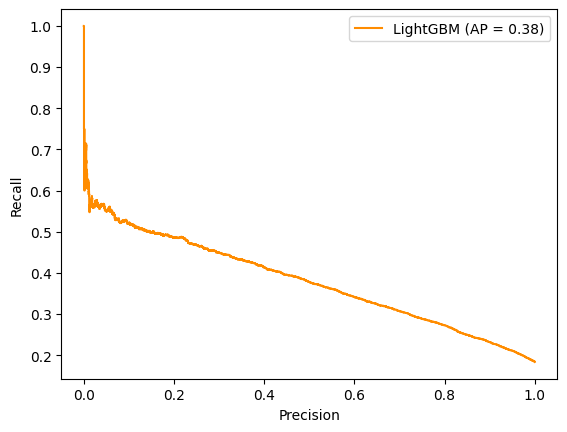

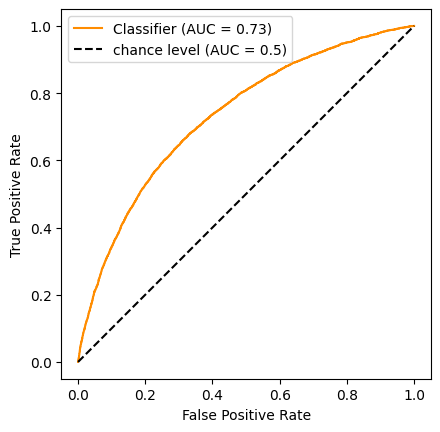

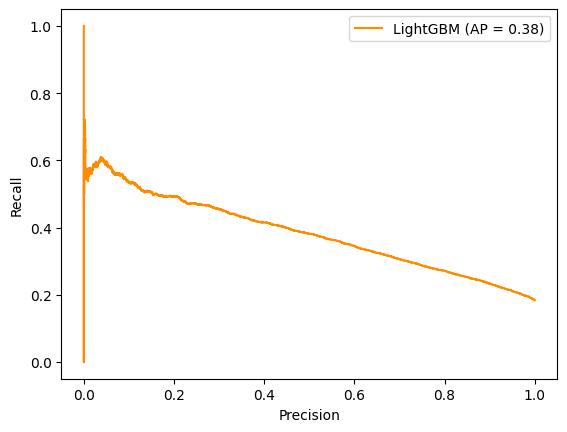

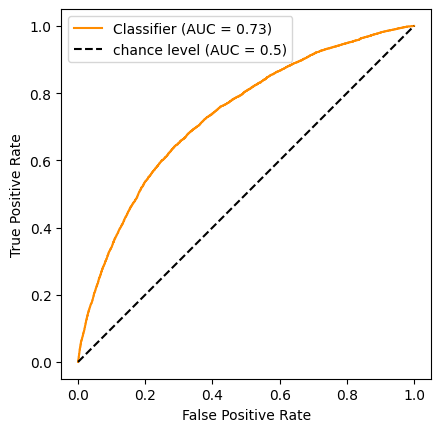

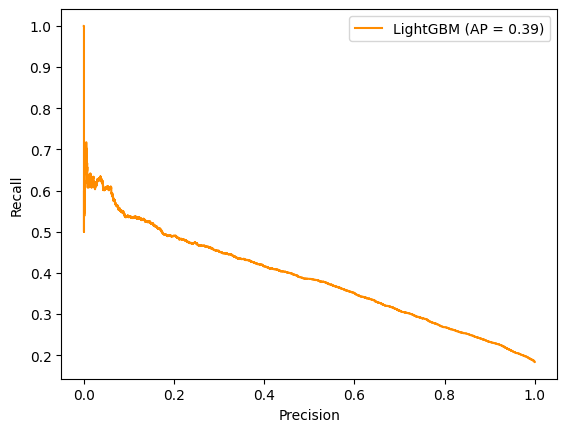

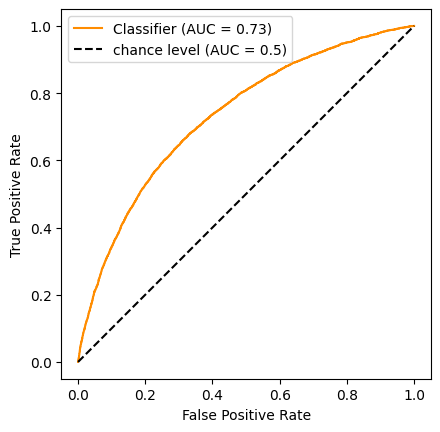

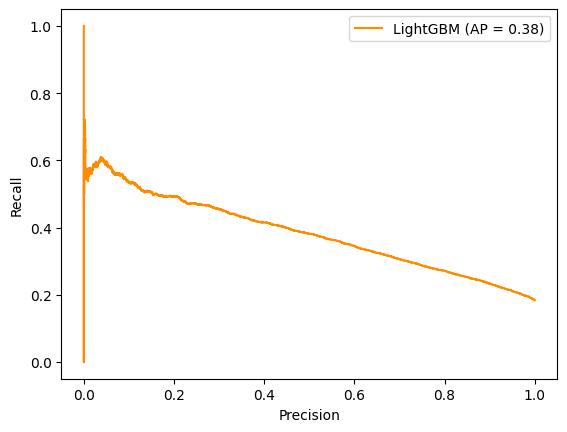

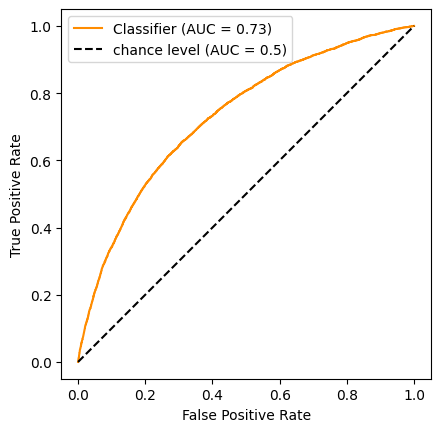

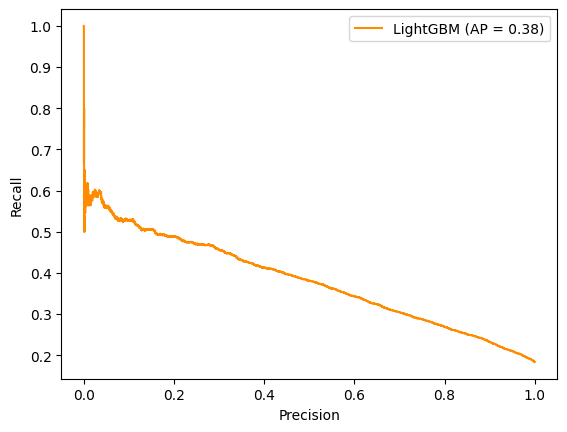

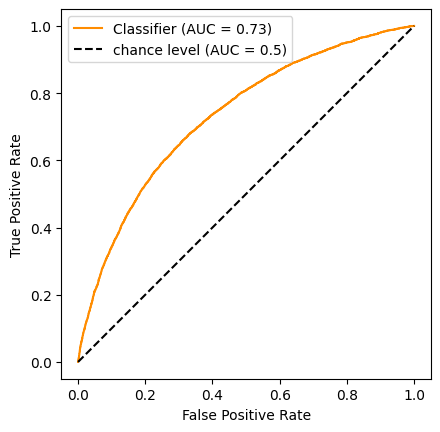

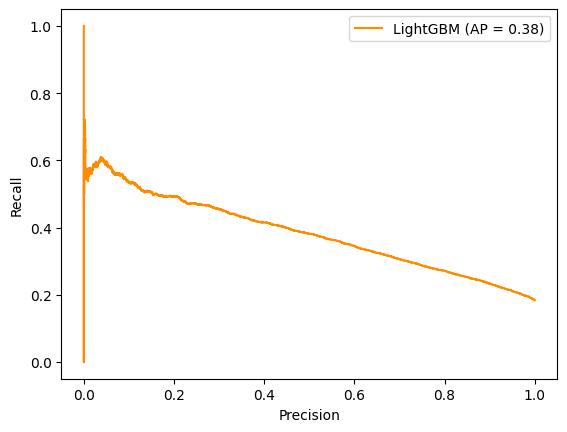

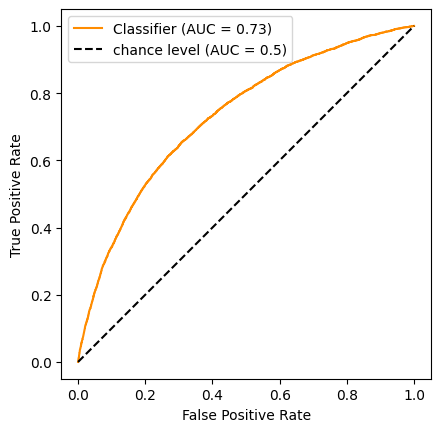

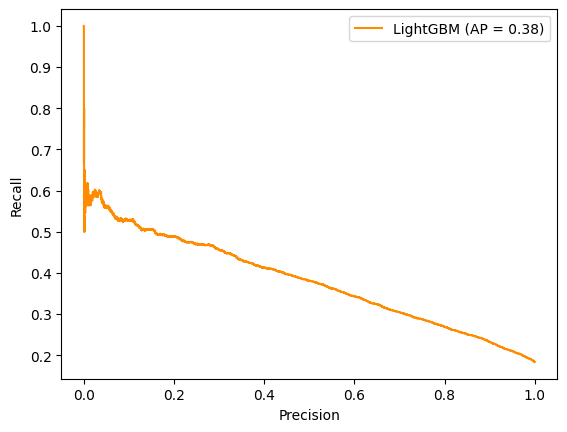

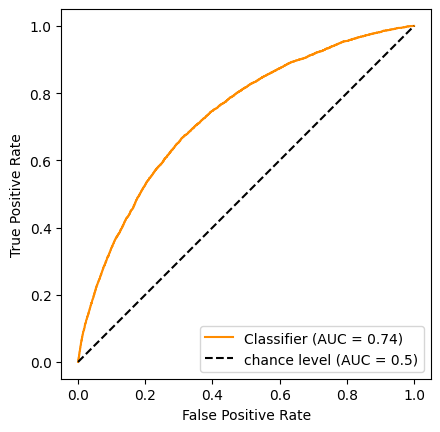

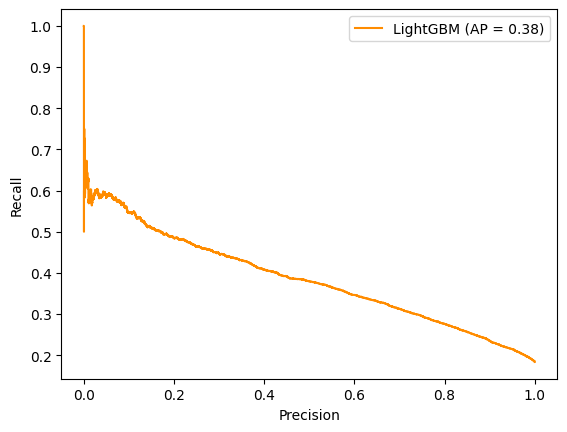

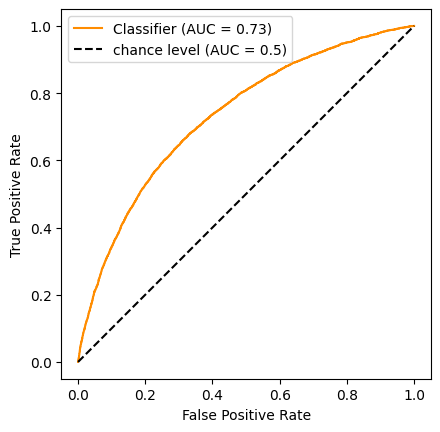

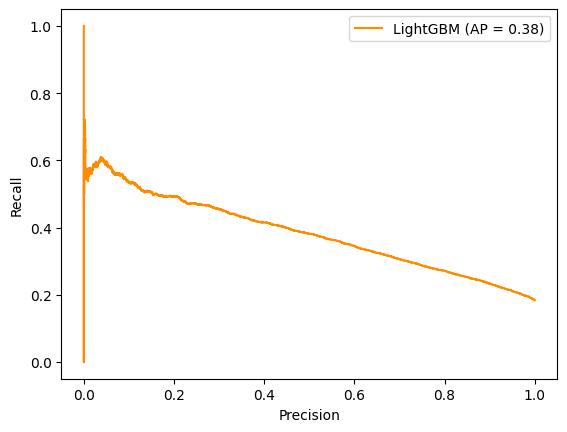

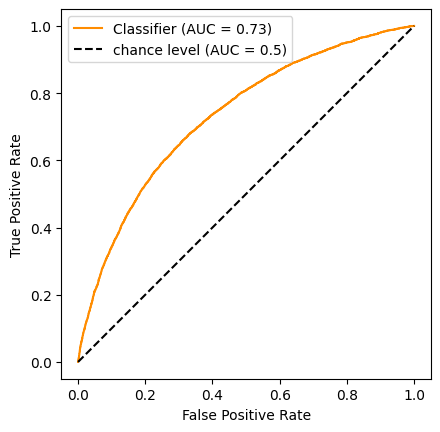

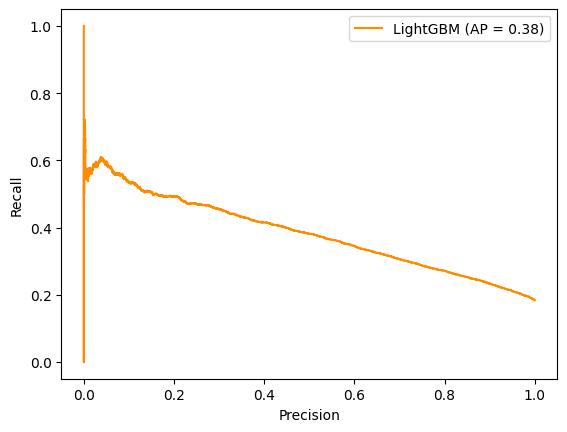

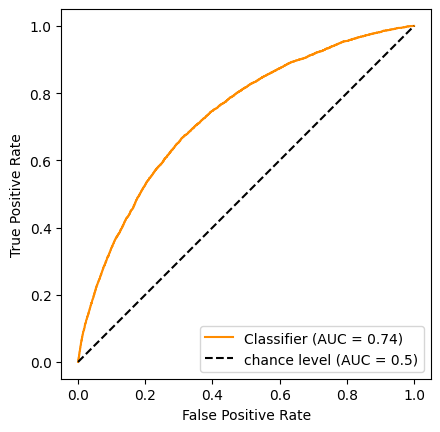

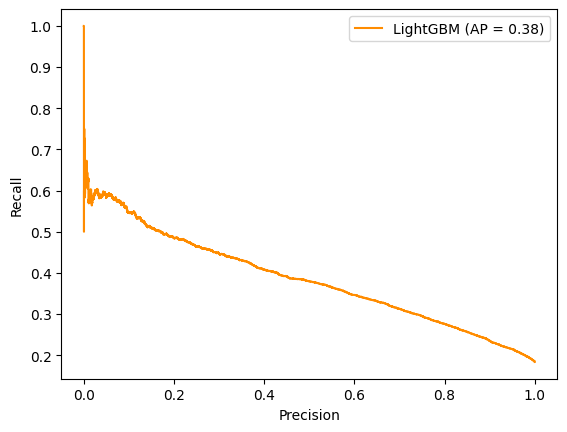

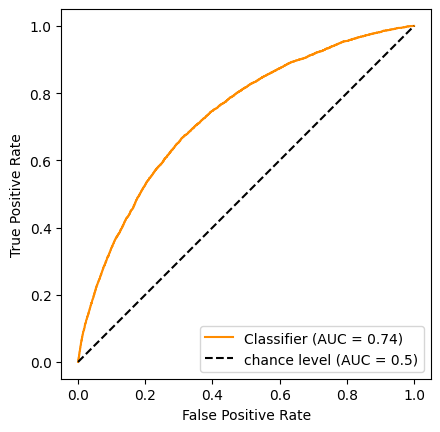

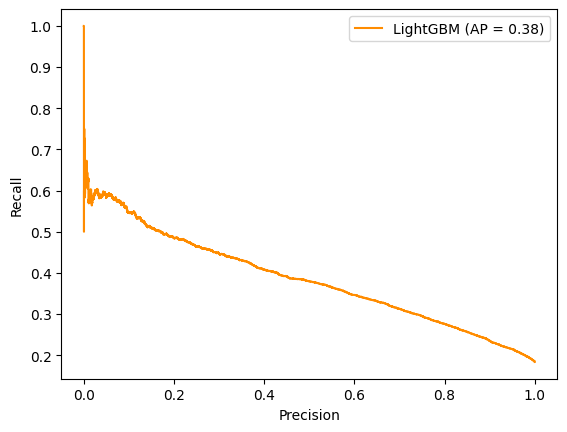

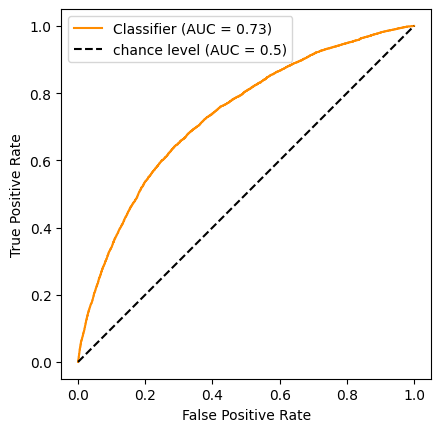

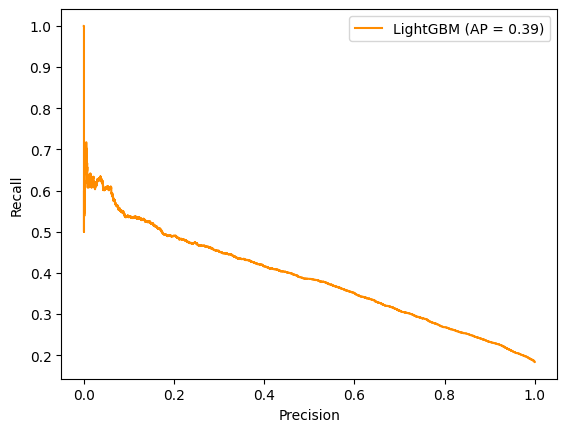

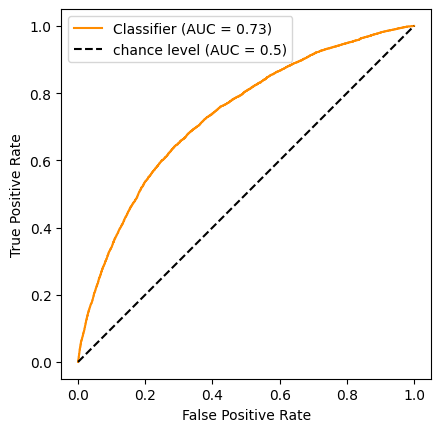

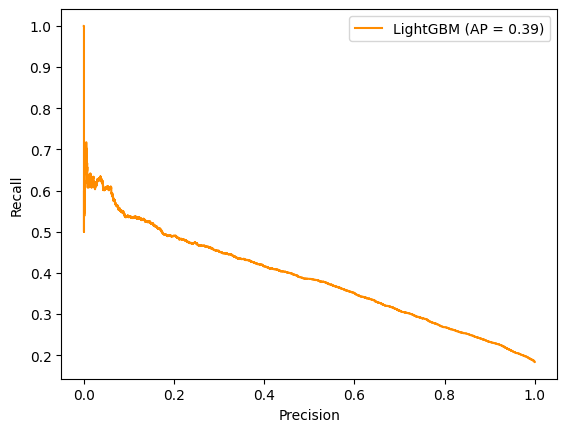

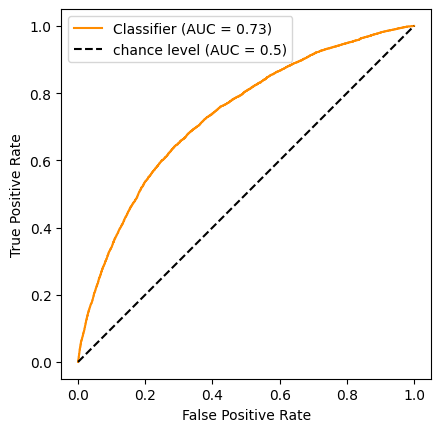

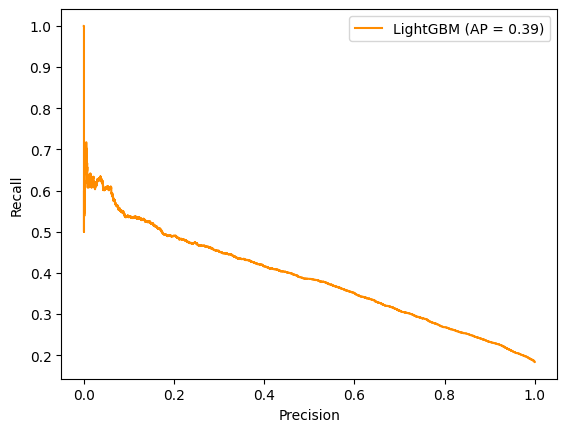

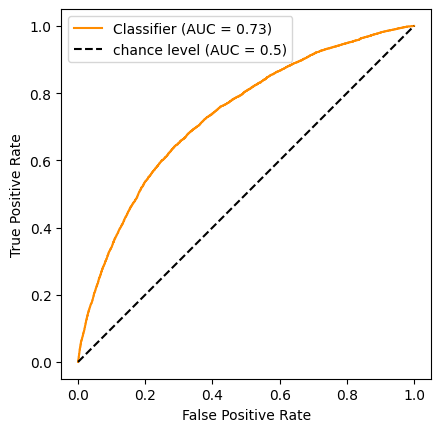

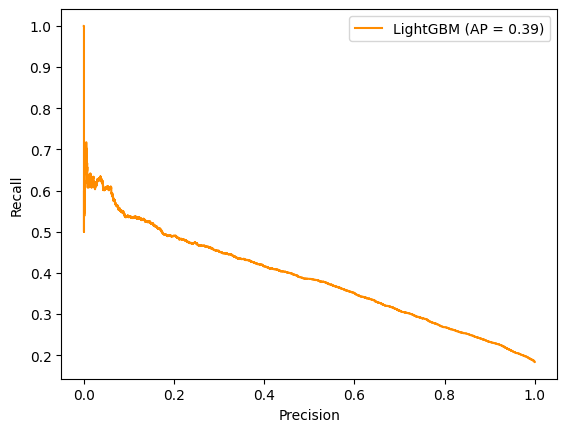

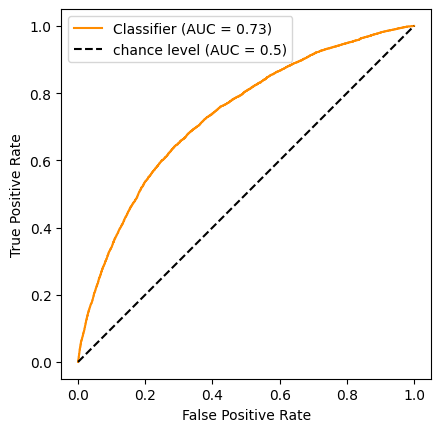

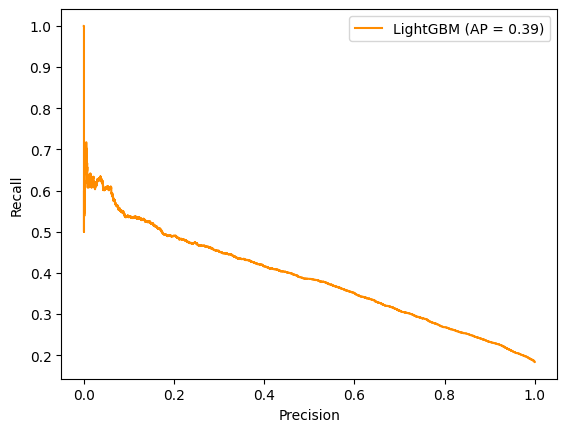

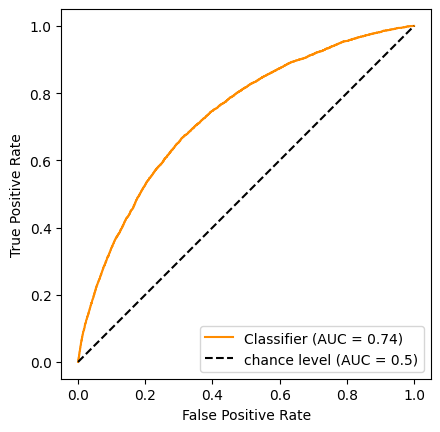

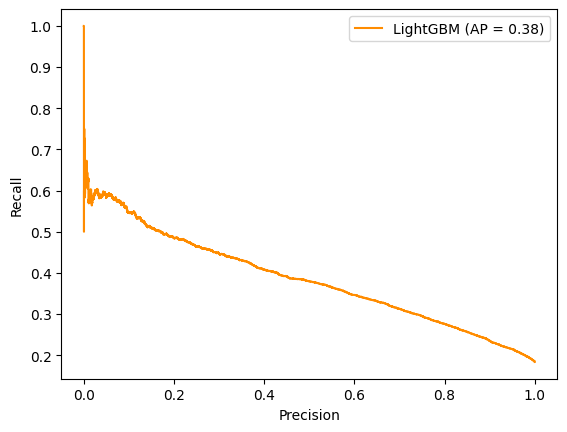

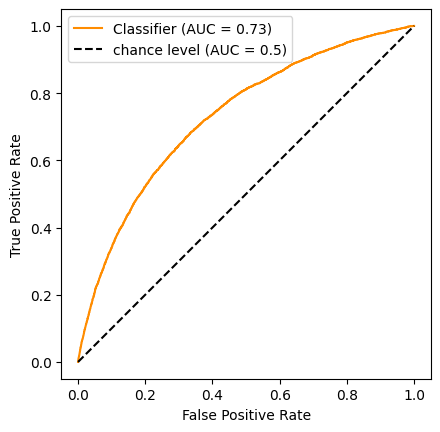

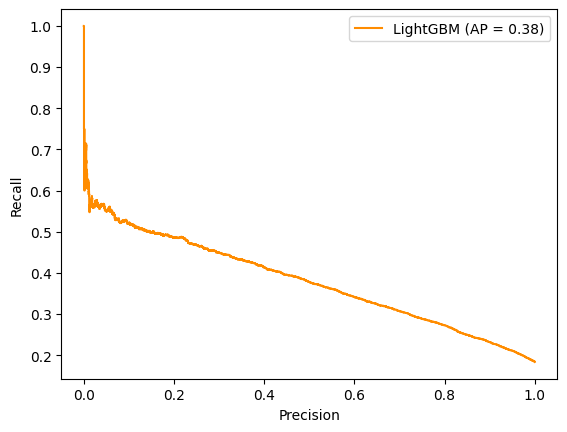

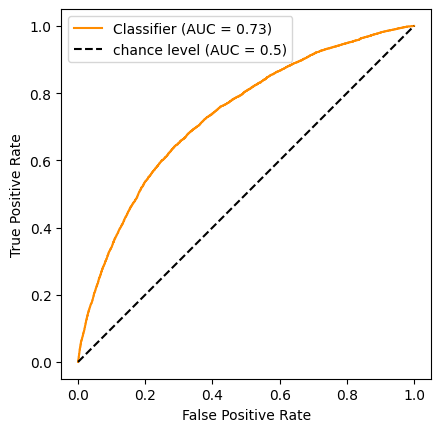

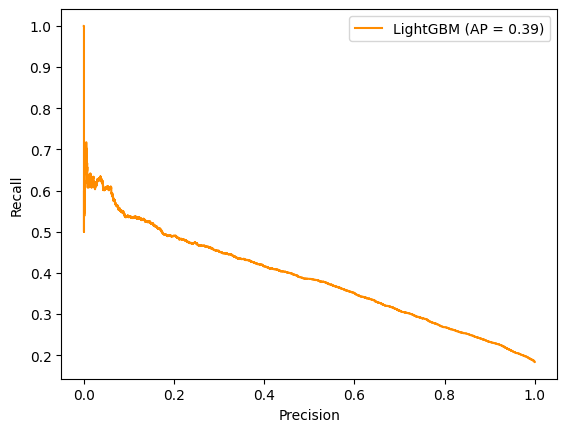

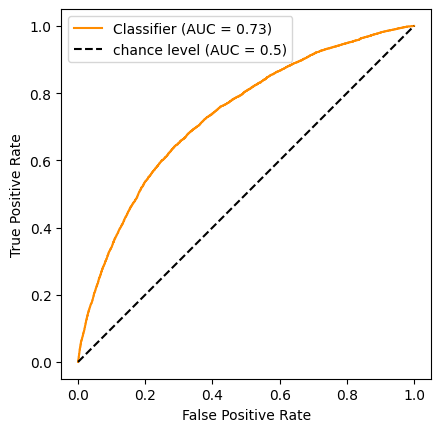

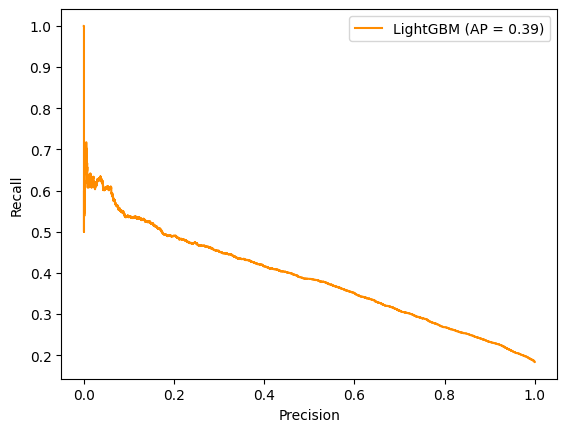

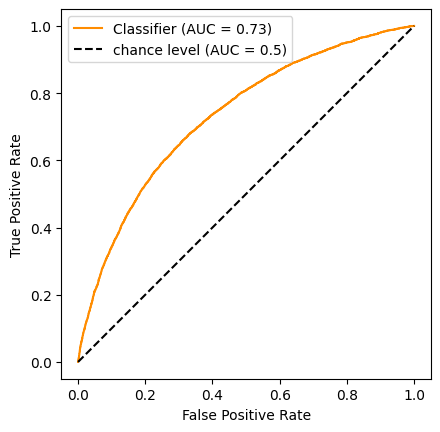

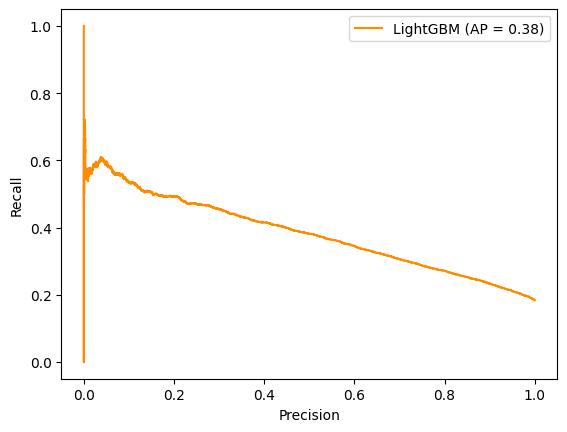

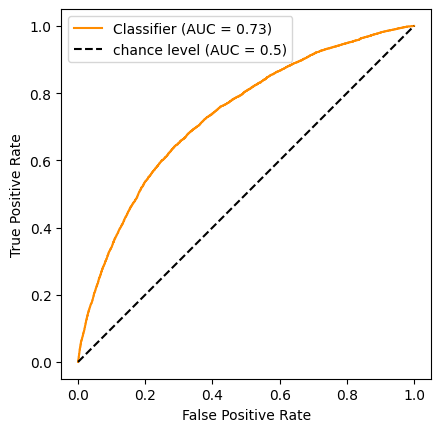

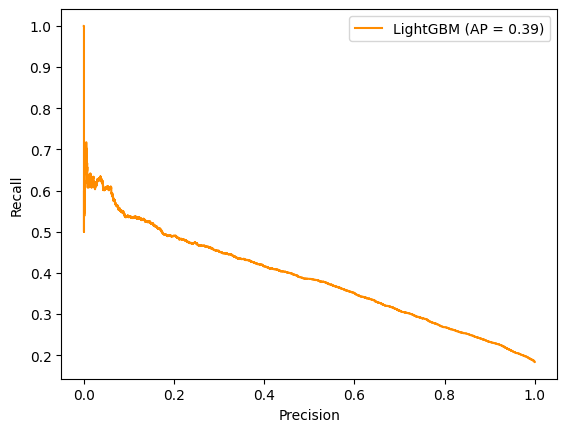

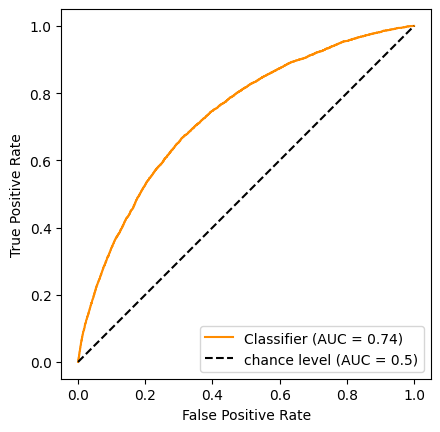

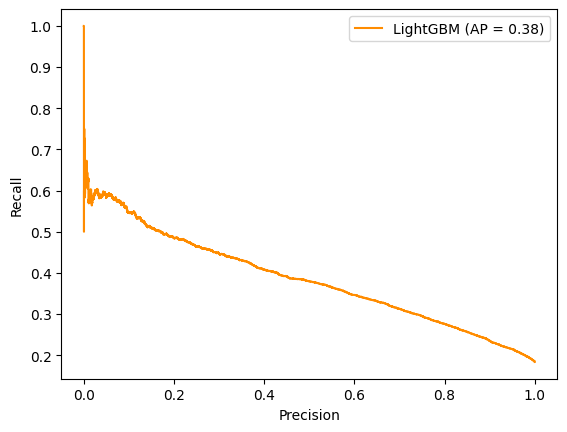

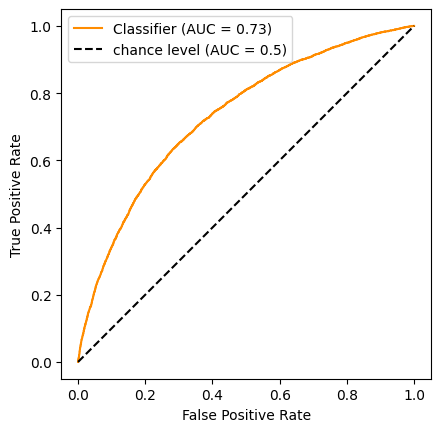

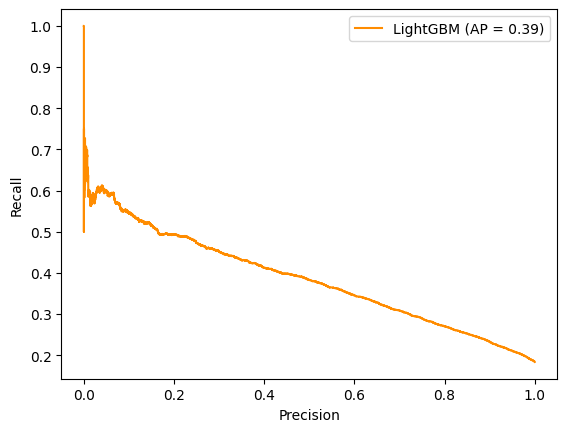

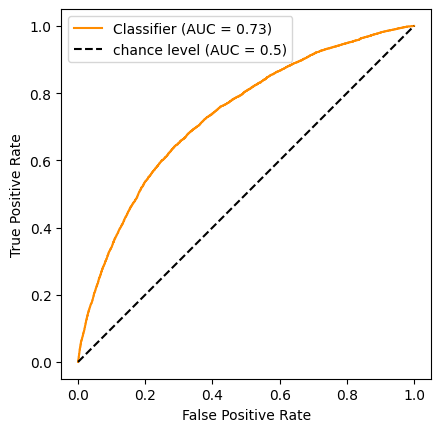

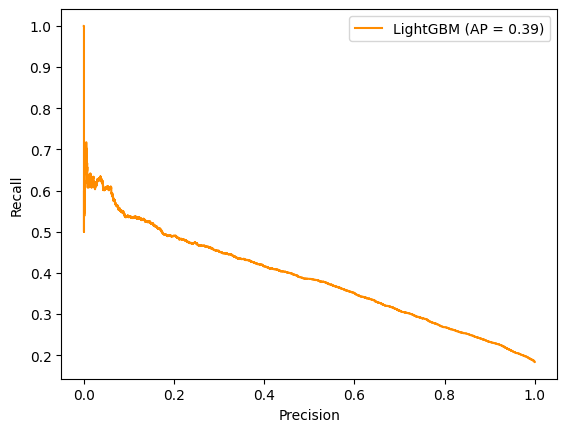

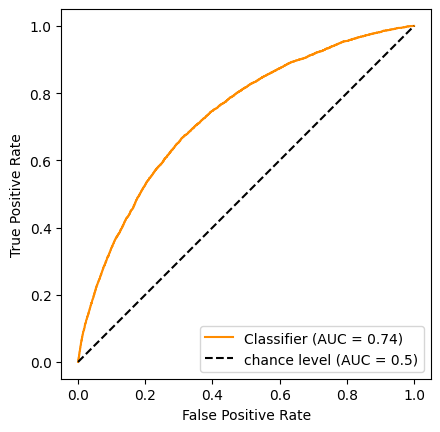

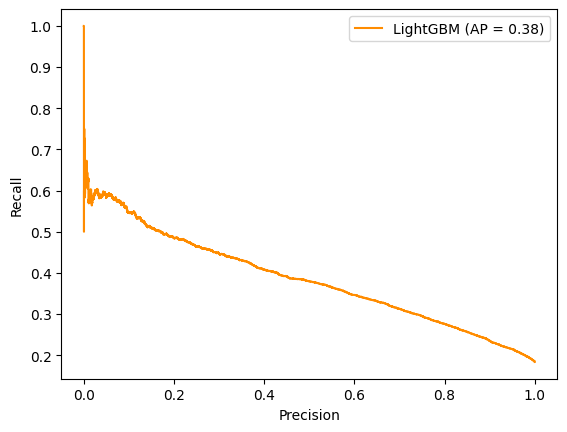

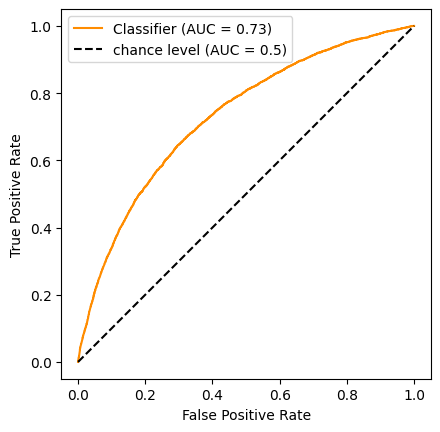

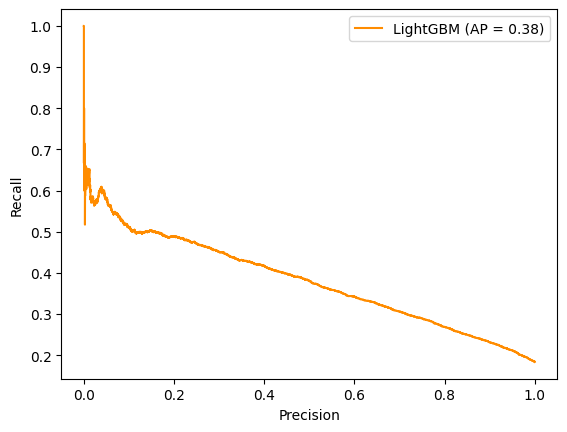

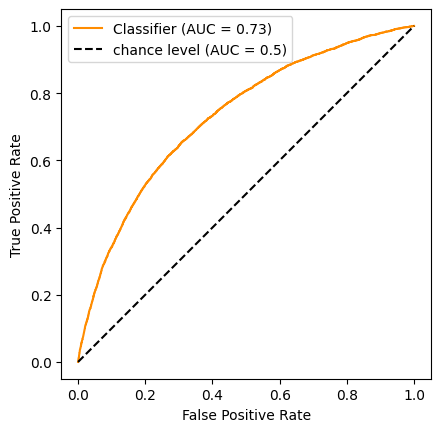

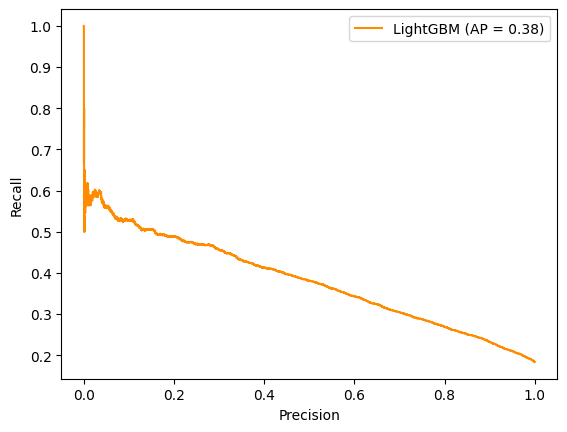

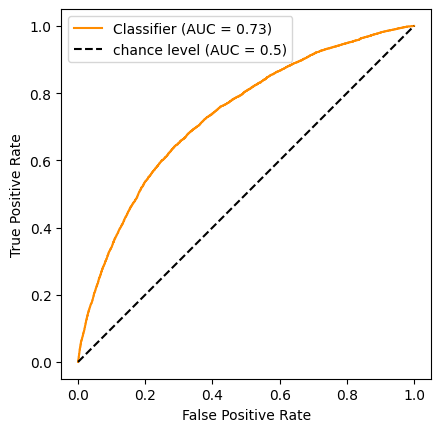

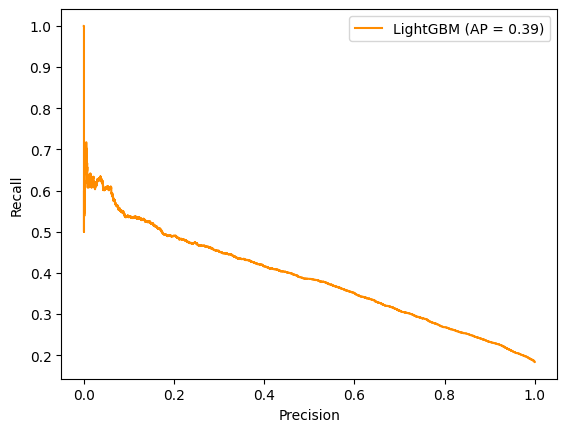

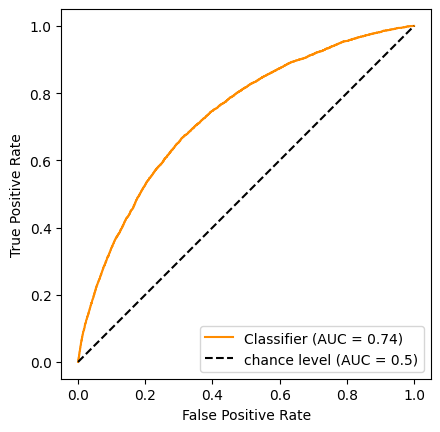

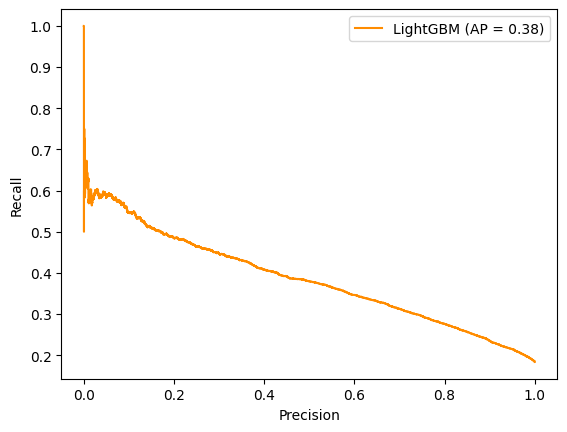

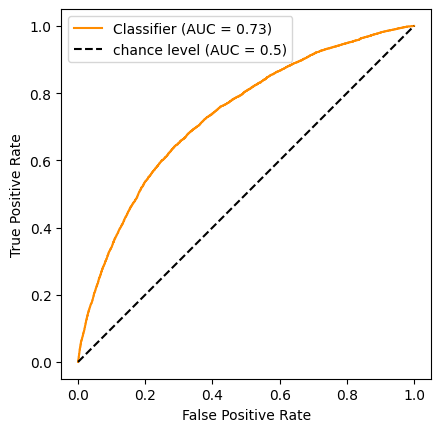

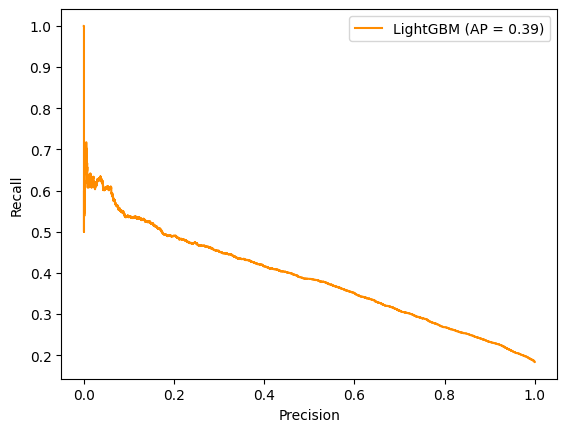

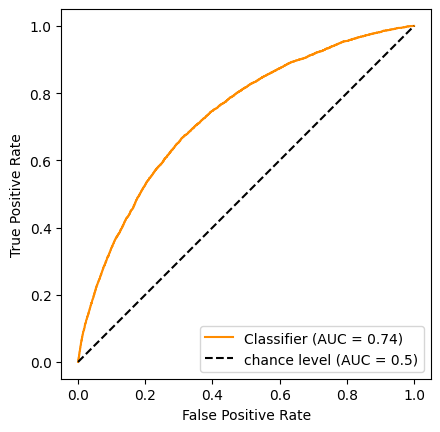

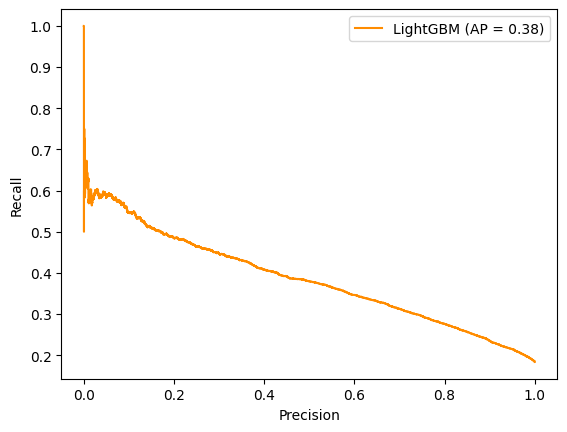

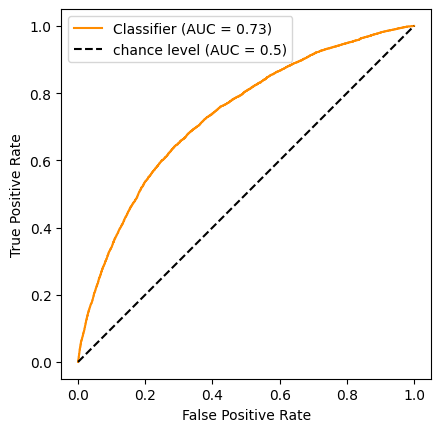

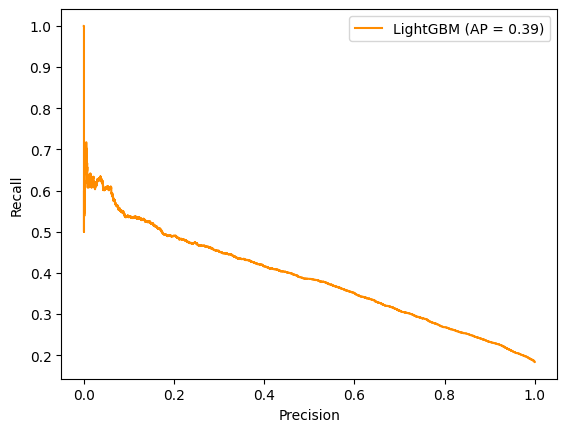

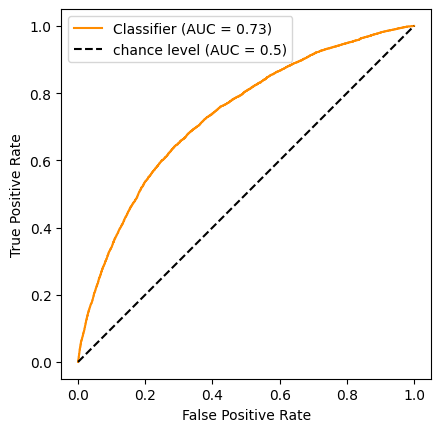

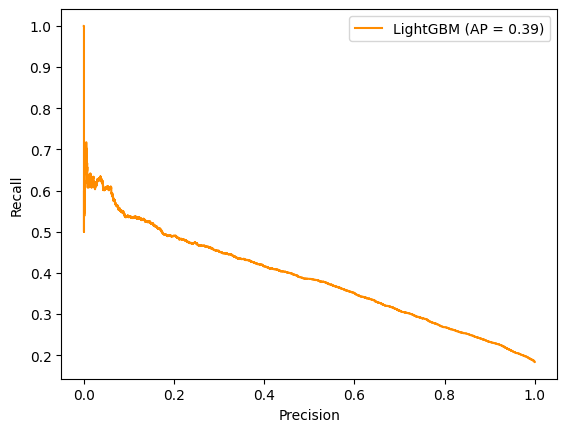

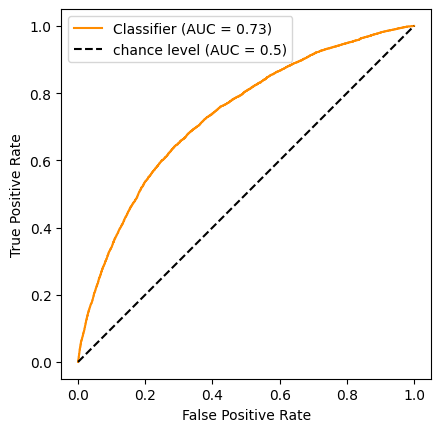

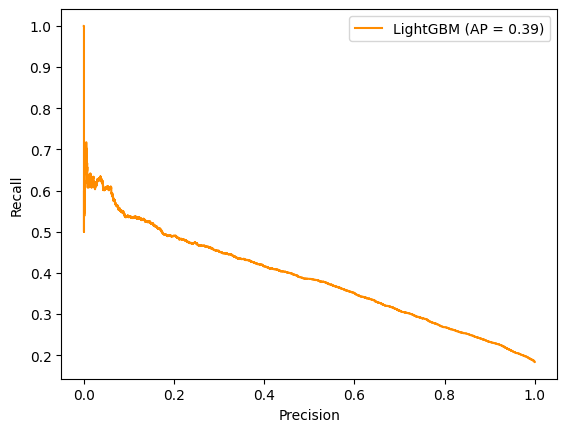

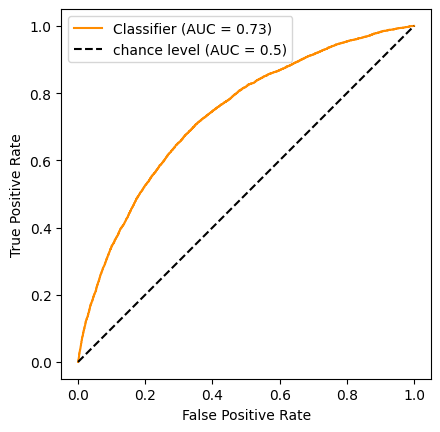

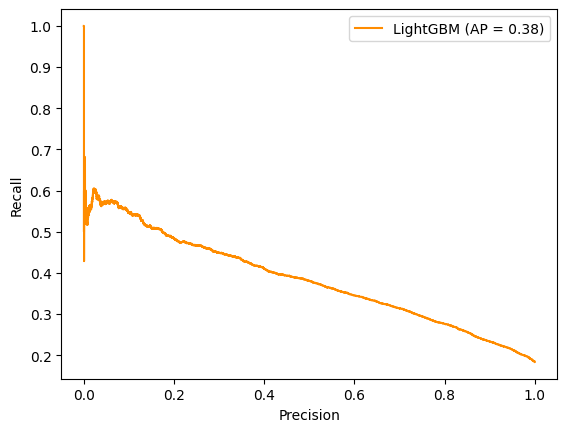

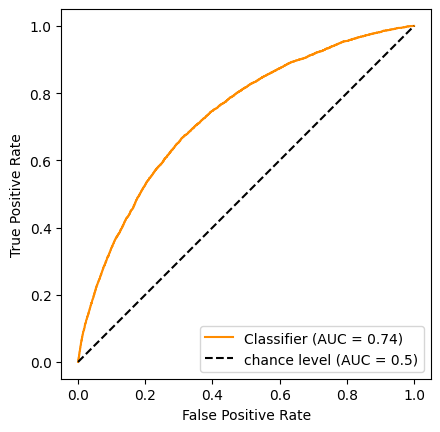

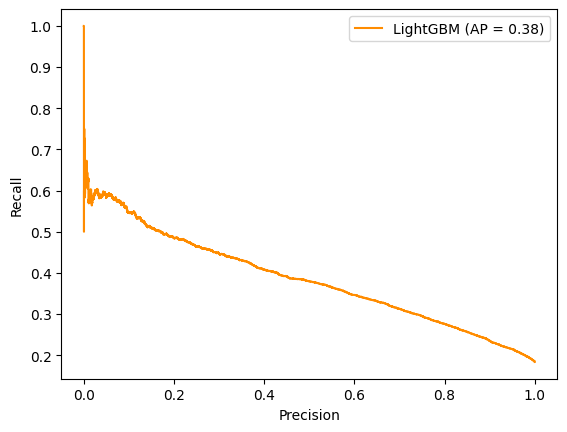

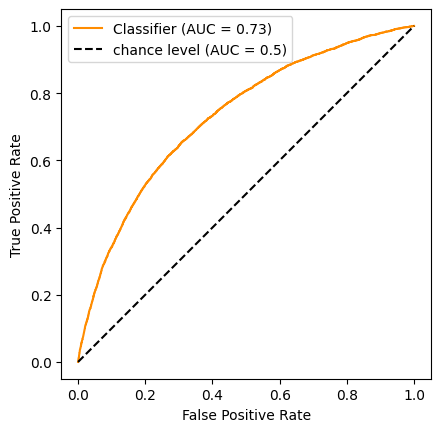

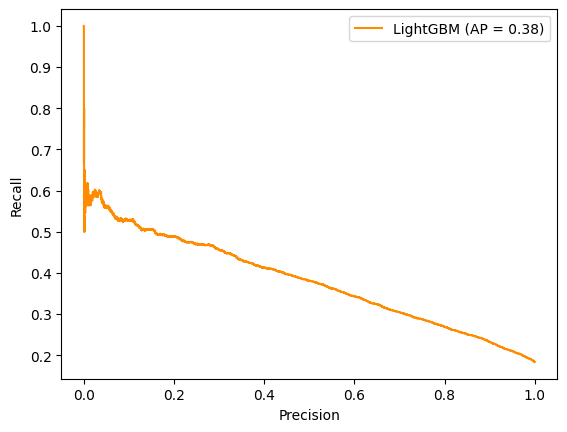

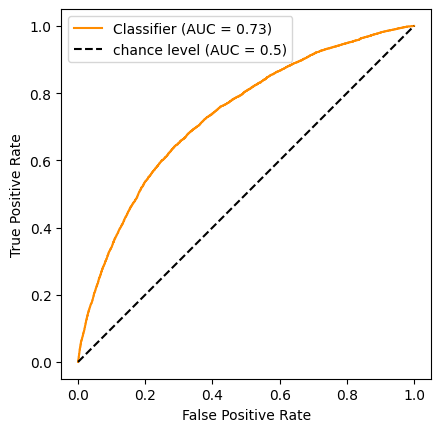

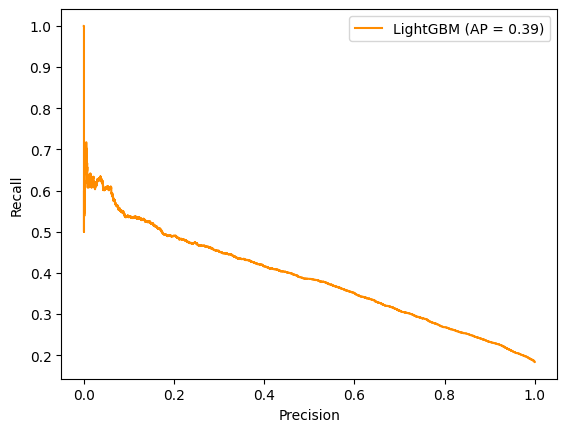

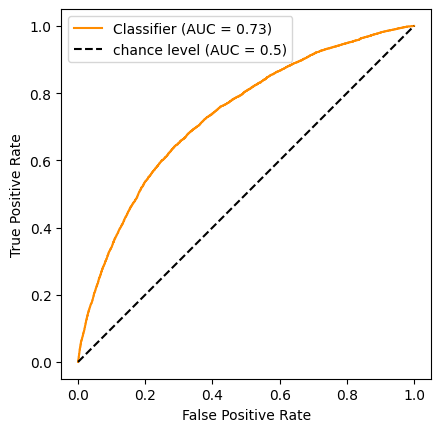

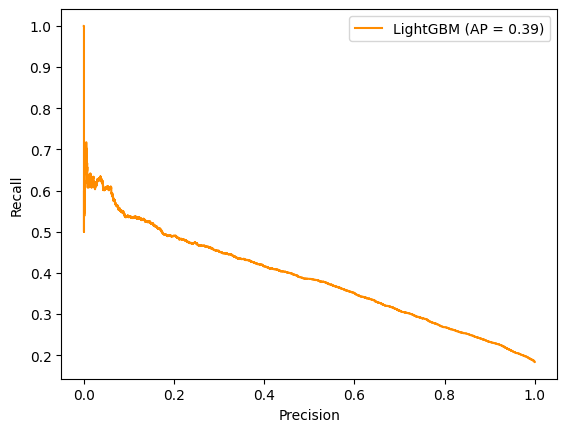

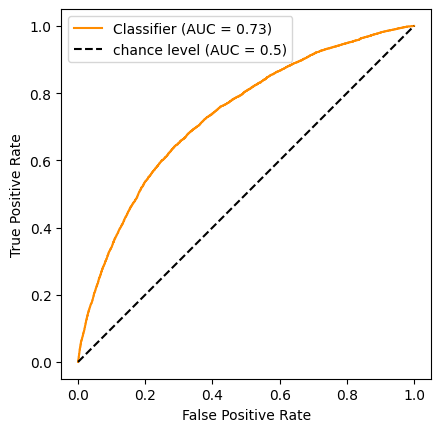

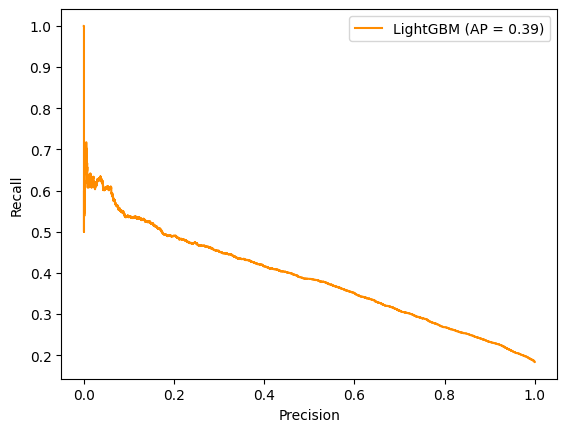

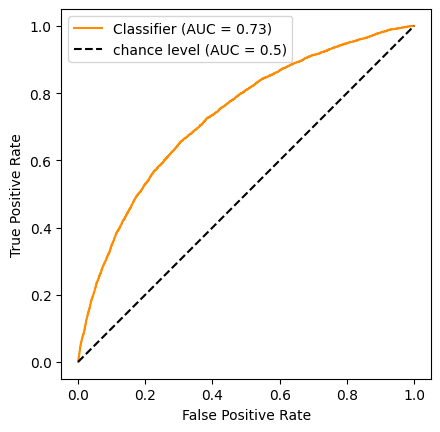

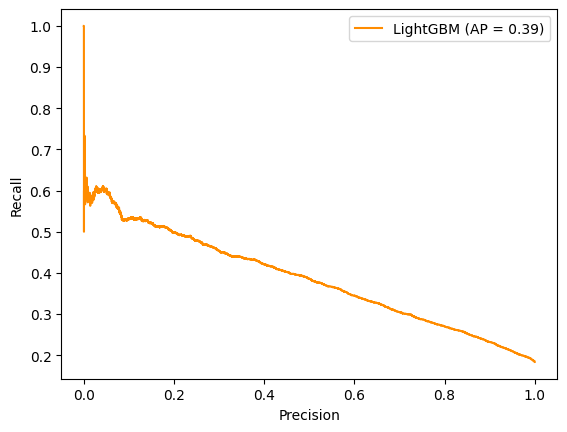

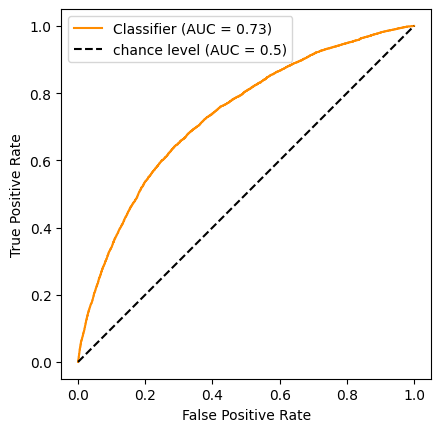

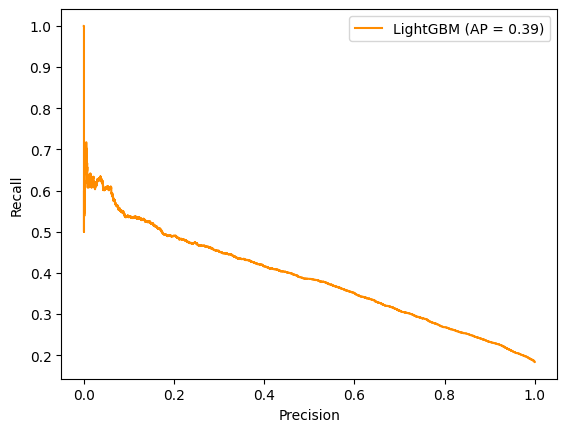

In [32]:
count = 1000 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)